<a href="https://colab.research.google.com/github/shivsharanrupesh/GenAI_Agents_Journey/blob/main/Langgraph/LangGraph_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction to LangGraph**
LangGraph is a framework for creating applications using graph-based workflows. Each node represents a function or computational step, and edges define the flow between these nodes based on certain conditions.

**Key Features:**
1. State Management
2. Flexible Routing
3. Persistence
4. Visualization

**Tutorial Overview: Text Analysis Pipeline**
In this tutorial, we'll demonstrate the power of LangGraph by building a multi-step text analysis pipeline. Our use case will focus on processing a given text through three key stages:

**Text Classification:** We'll categorize the input text into predefined categories (e.g., News, Blog, Research, or Other).

**Entity Extraction:** We'll identify and extract key entities such as persons, organizations, and locations from the text.

**Text Summarization:** Finally, we'll generate a concise summary of the input text.

This pipeline showcases how LangGraph can be used to create a modular, extensible workflow for natural language processing tasks. By the end of this tutorial, you'll understand how to construct a graph-based application that can be easily modified or expanded for various text analysis needs.



In [12]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [13]:
from openai import OpenAI
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')
llm = ChatOpenAI(model="gpt-4o-mini",api_key = api_key, temperature=0)


**Building the Text Processing Pipeline**

**Define State and Initialize LLM**

Here we define the State class to hold our workflow data and initialize the ChatOpenAI model.

In [14]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

**Define Node Functions**

These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.

In [15]:
def classification_node(state: State):
    ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}


def entity_extraction_node(state: State):
    ''' Extract all the entities (Person, Organization, Location) from the text '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(", ")
    return {"entities": entities}


def summarization_node(state: State):
    ''' Summarize the text in one short sentence '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}


**Create Tools and Build Workflow**

This cell builds the StateGraph workflow.

In [19]:
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification_node") # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

**Visualizing the Workflow**

This cell creates a visual representation of our workflow using Mermaid

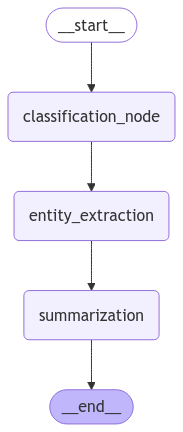

In [20]:
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

**Testing the Pipeline**

This cell runs a sample text through our pipeline and displays the results.

In [22]:
sample_text = """
Artificial Intelligence (AI) has become one of the most transformative technologies of the 21st century, and at the forefront of this revolution is OpenAI. Founded in December 2015, OpenAI has emerged as a leading force in AI research and development, pushing the boundaries of what machines can do and shaping the future of technology. In this blog, we’ll explore OpenAI’s journey, its groundbreaking achievements, and its impact on the world."""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: Blog

Entities: ['OpenAI']

Summary: OpenAI, founded in 2015, is a leading force in AI research and development, significantly shaping the future of technology.
